In [2]:
%run ./prelude.py --style=uncompressed --animation=movie

interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

Button(description='Run all cells below', style=ButtonStyle())

Matrix Multiply
Output - before


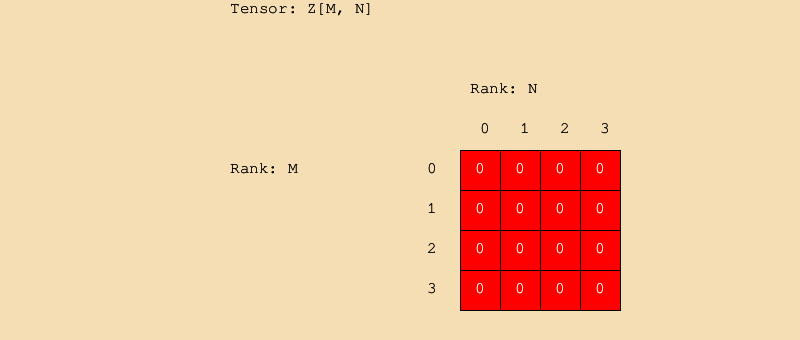

Output - after


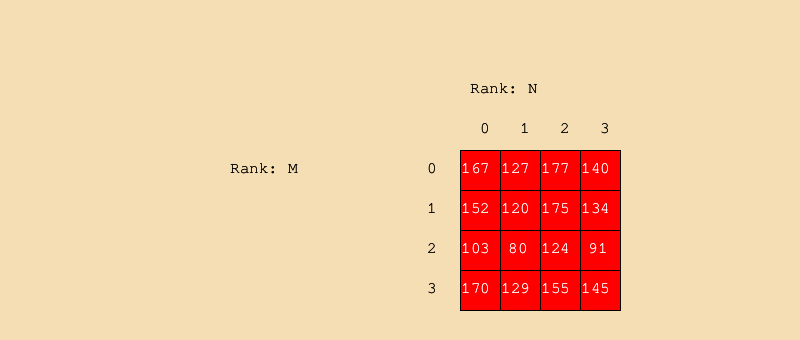

Create individual tensor images for each cycle: 0it [00:00, ?it/s]

Paste individual tensor images into frame for each cycle:   0%|          | 0/66 [00:00<?, ?it/s]

Render video frame for each cycle:   0%|          | 0/66 [00:00<?, ?it/s]

In [5]:
M1 = 2
M0 = 7
K1 = 2
K0 = 7
N1 = 2
N0 = 2
M = 4
M1 = M // M0
K = 4
K1 = K // K0
N = 4
N1 = N // N0

def create_z():
    """
    Create a fully populated z tensor
    """
    z = Tensor(rank_ids=["M", "N"], default='')
    z.setName("Z")
    z.setMutable(True)

    z_m = z.getRoot()
    #
    # Hack to fill in all the entries in z
    # This allows us to pretend the tensor is dense
    #
    n_fiber = Fiber(coords=range(N), initial=1)
    m_fiber = Fiber(coords=range(M), initial=1)

    for m, (z_n, _) in z_m << m_fiber:
        for n, (z_ref, _) in z_n << n_fiber:
            z_ref <<= 0
            
    return z

print("Matrix Multiply")
a_MK_raw = []
for m in range(M):
    a_MK_raw.append([random.randint(1, 9) for i in range(K)])
                 
b_KN_raw = []
for k in range(K):
    b_KN_raw.append([random.randint(1, 9) for i in range(N)])

a_MK = Tensor.fromUncompressed(["M", "K"], a_MK_raw)
b_KN = Tensor.fromUncompressed(["K", "N"], b_KN_raw)

a_MK.setName("A_MK").setColor("blue")
b_KN.setName("B_KN").setColor("green")

z_MN = create_z()

print("Output - before")
displayTensor(z_MN)

z = z_MN.getRoot()
a = a_MK.getRoot()
b = b_KN.getRoot()

canvas = createCanvas(a_MK, b_KN, z_MN)
for m in range(M):
    a_tile = [ (m, kt) for kt in range(K)]
    for n in range(N):
        b_tile = [ (kt, n) for kt in range(K)]
        z_tile = (m, n)
        for k in range(K):
            
            z[m][n] += a[m][k] * b[k][n]
            addActivity(canvas, a_tile, b_tile, z_tile, worker="W")
            addFrame(canvas, (m,k), (k,n), (m,n))
            

print("Output - after")
displayTensor(z)

displayCanvas(canvas)
    

Convolutional Step w/ 7x7 Filters
Output - before


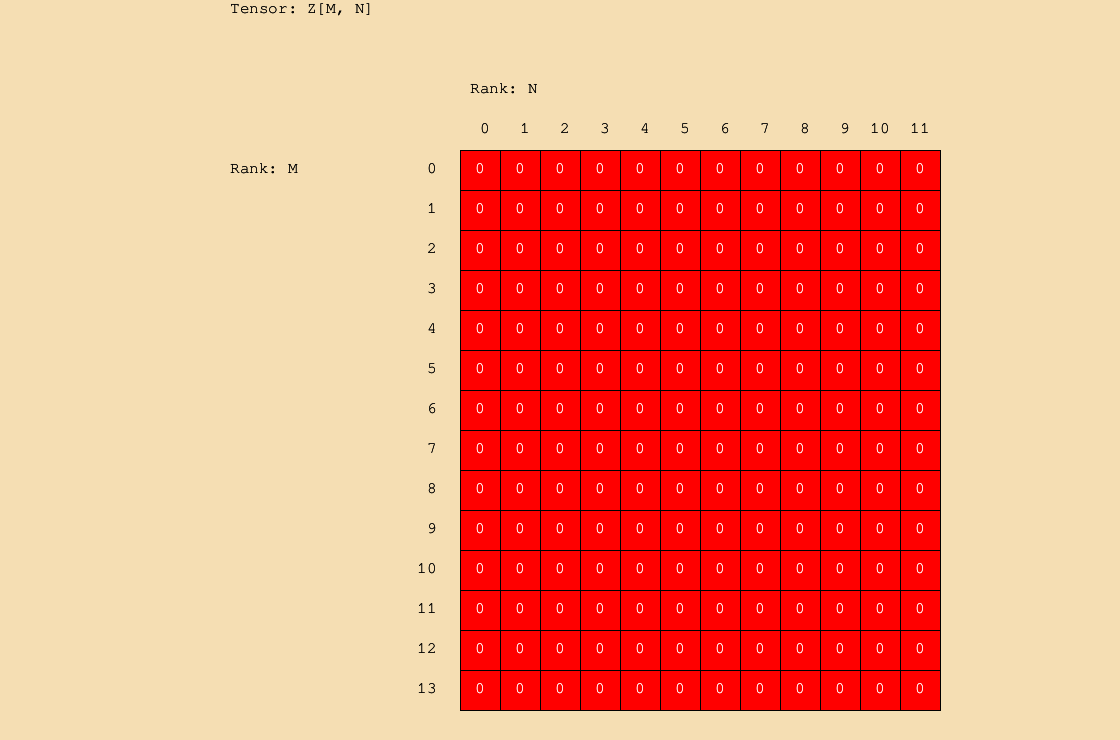

Output - after


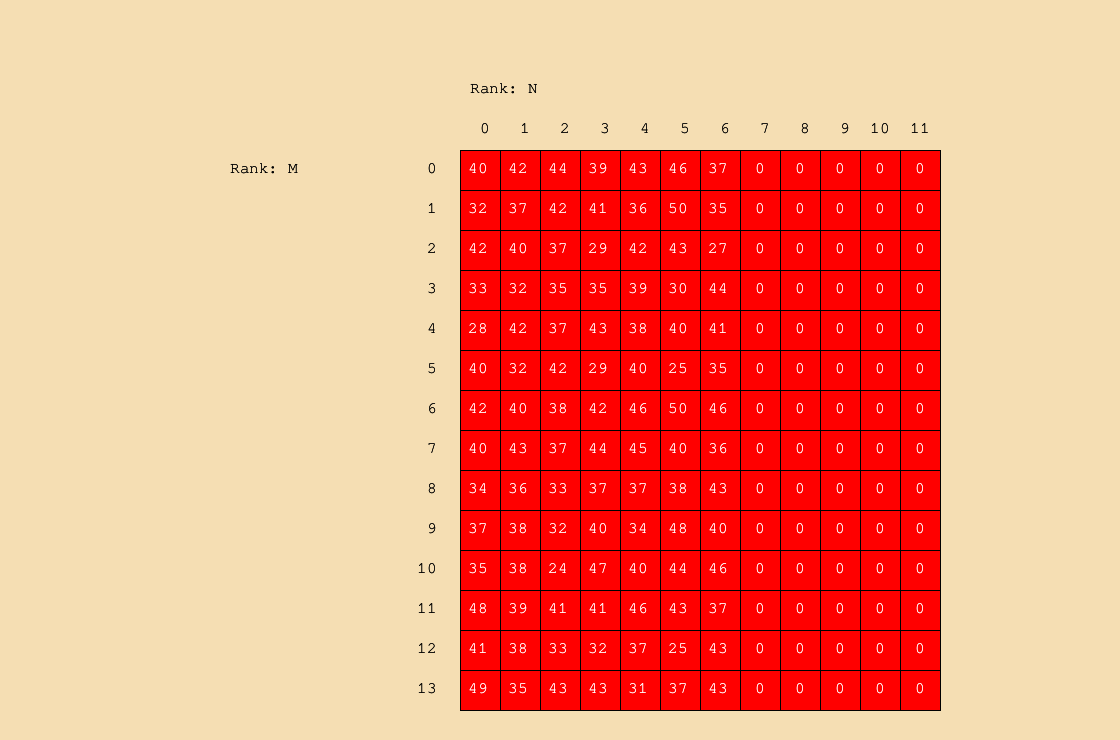

Create individual tensor images for each cycle: 0it [00:00, ?it/s]

Paste individual tensor images into frame for each cycle:   0%|          | 0/10 [00:00<?, ?it/s]

Render video frame for each cycle:   0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
# FILTER USAGE IN EYERISS-LIKE
W = 7
H = 7
M = 14
N = 12
M_div_W = M//W
N_div_H = N//H
num_steps = 8

def create_out():
    """
    Create a fully populated z tensor
    """
    z = Tensor(rank_ids=["M", "N"], default='')
    z.setName("Parallel Filter Executions Without Cache Reloading on PEs ")
    z.setMutable(True)

    z_m = z.getRoot()
    #
    # Hack to fill in all the entries in z
    # This allows us to pretend the tensor is dense
    #
    n_fiber = Fiber(coords=range(N), initial=1)
    m_fiber = Fiber(coords=range(M), initial=1)

    for m, (z_n, _) in z_m << m_fiber:
        for n, (z_ref, _) in z_n << n_fiber:
            z_ref <<= 0
            
    return z

print("Convolutional Step w/ 7x7 Filters")

# data_raw = []
# for m in range(M):
#     a_MK_raw.append([random.randint(1, 9) for i in range(K)])
                 
# b_KN_raw = []
# for k in range(K):
#     b_KN_raw.append([random.randint(1, 9) for i in range(N)])

# a_MK = Tensor.fromUncompressed(["M", "K"], a_MK_raw)
# b_KN = Tensor.fromUncompressed(["K", "N"], b_KN_raw)

# a_MK.setName("A_MK").setColor("blue")
# b_KN.setName("B_KN").setColor("green")

z_MN = create_z()

print("Output - before")
displayTensor(z_MN)

z = z_MN.getRoot()


canvas = createCanvas(z_MN)
parallel_updates = [[(a + W * m, b + H * n) for a in range(W) for b in range(H)] for m in range(M_div_W) for n in range(N_div_H)]
workers = ["W", "X", "Y"]
colors = ["blue", "green", "purple"]
for _ in range(num_steps):
    for i in range(M_div_W):
        for j in range(N_div_H):
            for x, y in parallel_updates[i * N_div_H + j]:
                z[x][y] += random.randint(1, 9)
            for update in parallel_updates[i * N_div_H + j]:
                addActivity(canvas, update, worker=workers[i * N_div_H + j])
    addFrame(canvas)
            

print("Output - after")
displayTensor(z)

displayCanvas(canvas)
    